# **Requisits d'execució**

In [15]:
!git clone https://github.com/OscarMoliina/betterlifebetterhealth.git

fatal: destination path 'betterlifebetterhealth' already exists and is not an empty directory.


In [3]:
!pip3 install pyspark
#!pip3 install duckdb
import pyspark

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, mean, when, lit, count
from pyspark.sql.window import Window
from pyspark.sql.functions import mean
from pyspark.sql.functions import mean
from pyspark.sql.types import IntegerType, DoubleType

import pandas as pd
import matplotlib.pyplot as plt
import duckdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=f5f381d4ddf93a3b14afd674f2d7bc60dc88a78a33394f23df3185e7e5f38ba1
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


# **Preprocessament superficial de la base de dades**

### *Lectura de les bases de dades*

In [68]:
spark = SparkSession.builder \
    .appName("Preprocessing") \
    .config("spark.jars", "/content/betterlifebetterhealth/src/duckdb.jar") \
    .getOrCreate()

dem = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:duckdb:/content/betterlifebetterhealth/src/demography_df.db") \
    .option("driver", "org.duckdb.DuckDBDriver") \
    .option("dbtable", "demography_df") \
    .load()

mh = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:duckdb:/content/betterlifebetterhealth/src/mh_df.db") \
    .option("driver", "org.duckdb.DuckDBDriver") \
    .option("dbtable", "mh_df") \
    .load()

soc = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:duckdb:/content/betterlifebetterhealth/src/society_df.db") \
    .option("driver", "org.duckdb.DuckDBDriver") \
    .option("dbtable", "society_df") \
    .load()

In [17]:
dem.describe().columns

['summary',
 'NAME',
 'YR',
 'AREA_KM2',
 'CBR',
 'CDR',
 'DEATHS',
 'E0',
 'GRR',
 'IMR',
 'MEDAGE',
 'MR0_4',
 'POP_DENS',
 'genc standard countries and areas',
 'code']

### *Homogenització dels noms de les columnes*

    Adaptem el nom de les columnes de la base de dades demogràfiques amb l'objectiu d'homogenitzar l'estil.

In [44]:
mh.show() # Name, Country, Entity

+-----+-----------+----+----+-----------------+--------------------+--------------------+---------------------+----------------------+--------------+-------------------------+
|index|     Entity|Code|Year|Schizophrenia (%)|Bipolar disorder (%)|Eating disorders (%)|Anxiety disorders (%)|Drug use disorders (%)|Depression (%)|Alcohol use disorders (%)|
+-----+-----------+----+----+-----------------+--------------------+--------------------+---------------------+----------------------+--------------+-------------------------+
|    0|Afghanistan| AFG|1990|          0.16056|            0.697779|            0.101855|              4.82883|              1.677082|      4.071831|                 0.672404|
|    1|Afghanistan| AFG|1991|         0.160312|            0.697961|            0.099313|              4.82974|              1.684746|      4.079531|                 0.671768|
|    2|Afghanistan| AFG|1992|         0.160135|            0.698107|            0.096692|             4.831108|         

In [69]:
nous = {
    "NAME": "Country",
    "YR": "Year",
    "AREA_KM2": "Area_Km2",
    "DEATHS": "Deaths",
    "MEDAGE": "Medage",
    "POP_DENS": "Pop_Dens",
    "genc standard countries and areas": "GSCA",
    "code": "Code"
}

for columna_original, nom_nou in nous.items():
    dem = dem.withColumnRenamed(columna_original, nom_nou)

mh = mh.withColumnRenamed("Entity", "Country")


### *Filtratge de les Bases de Dades*


    Seleccionem els anys presents en les tres bases de dades, seran els que determinaran els fragments de bases de dades amb els quals treballarem.

In [70]:
anys_soc = soc.select('Year').distinct()
anys_mh = mh.select('Year').distinct()
anys_dem = dem.select('Year').distinct()

intersecció = anys_soc.intersect(anys_mh).intersect(anys_dem).orderBy('Year')
anys_coincidents = [row['Year'] for row in intersecció.collect()]
print(anys_coincidents)

['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016']


    Ara ja tenim els anys en els quals ens volem centrar, a continuació filtarem les files de les bases de dades segons els anys.


In [71]:
dem_mod = dem.filter(dem['Year'].isin(anys_coincidents))
soc_mod = soc.filter(soc['Year'].isin(anys_coincidents))
mh_mod = mh.filter(mh['Year'].isin(anys_coincidents))

    També cal filtrar per països, ja que no totes les bases de dades tenen la mateixa informació.

In [72]:
paisos_soc = soc_mod.select('Country').distinct()
paisos_mh = mh_mod.select('Country').distinct()
paisos_dem = dem_mod.select('Country').distinct()

intersecció_2 = paisos_soc.intersect(paisos_mh).intersect(paisos_dem).orderBy('Country')
paisos_coincidents = [row['Country'] for row in intersecció_2.collect()]
print(paisos_coincidents)

['Albania', 'Armenia', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Canada', 'Croatia', 'Cyprus', 'Denmark', 'Estonia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy', 'Kazakhstan', 'Kyrgyzstan', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Montenegro', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Tajikistan', 'Turkey', 'Turkmenistan', 'Ukraine', 'United Kingdom', 'United States', 'Uzbekistan']


In [73]:
dem_mod_ = dem_mod.filter(dem_mod['Country'].isin(paisos_coincidents))
soc_mod_ = soc_mod.filter(soc_mod['Country'].isin(paisos_coincidents))
mh_mod_ = mh_mod.filter(mh_mod['Country'].isin(paisos_coincidents))

### *Eliminació de columnes*

In [77]:
# Eliminar la columna 'Code'
dem = dem.drop('Code')

### *Imputació missing data*

In [78]:
# IDENTIFICAR COLUMNES AMB MISSING DATA:
from pyspark.sql.functions import col, count

# Calcular el número total de filas
total_rows = dem.count()

# Encontrar las columnas con valores NA
na_columns = []
for column in dem.columns:
    # Contar los valores no nulos en la columna actual
    non_na_count = dem.agg(count(col(column)).alias('non_na_count')).collect()[0]['non_na_count']
    # Si el conteo de no-nulos es menor que el total de filas, la columna tiene NAs
    if non_na_count < total_rows:
        na_columns.append(column)

# Imprimir las columnas con valores NA
print("Columnas con valores NA:", na_columns)


Columnas con valores NA: ['CBR', 'CDR', 'Deaths', 'E0', 'GRR', 'IMR', 'Medage', 'MR0_4']


**KMEANS**

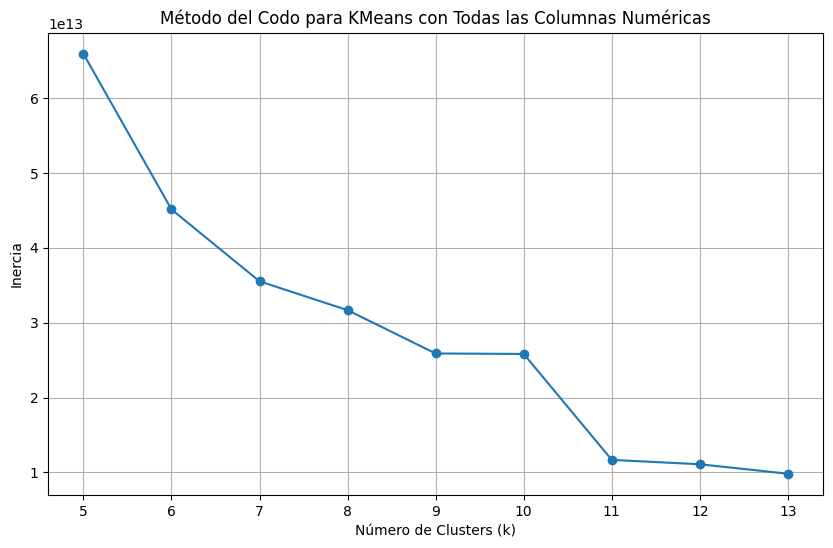

In [62]:
# TRIAR VALOR ÒPTIM DE K

# Identificar columnas numéricas
numeric_cols = [field.name for field in dem.schema.fields if isinstance(field.dataType, (pyspark.sql.types.IntegerType, pyspark.sql.types.DoubleType))]

# Calcular la media para imputar valores faltantes en las columnas numéricas
mean_values = {col: dem.select(mean(col)).first()[0] for col in numeric_cols}
# Imputar los valores faltantes con la media de cada columna
dem_filled = dem.na.fill(mean_values)

# Configurar VectorAssembler con las columnas numéricas imputadas
vecAssembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
dem_features = vecAssembler.transform(dem_filled)

# Rango de valores de k para evaluar
k_values = range(5, 14)

# Lista para almacenar los resultados de inercia para cada k
inertias = []

for k in k_values:
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(dem_features)

    # Calcular la inercia y agregarla a la lista
    inertia = model.summary.trainingCost
    inertias.append(inertia)

# Convertir los resultados a un DataFrame de pandas para facilitar la visualización
df_results = pd.DataFrame({'K': k_values, 'Inertia': inertias})

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(df_results['K'], df_results['Inertia'], marker='o')
plt.title('Método del Codo para KMeans con Todas las Columnas Numéricas')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.xticks(k_values)
plt.grid(True)
plt.show()


In [80]:
#IMPUTAR AMB VALOR DE K TROBAT (9)

impute_cols = ['CBR', 'CDR', 'Deaths', 'E0', 'GRR', 'IMR', 'Medage', 'MR0_4']

# Marcar los valores faltantes antes de la imputación temporal
for col_name in impute_cols:
    dem = dem.withColumn(f"{col_name}_was_na", col(col_name).isNull())

# Imputación temporal de valores faltantes para la ejecución de KMeans
for col_name in impute_cols:
    mean_value = dem.select(mean(col(col_name)).alias(col_name)).collect()[0][col_name]
    dem = dem.na.fill(mean_value, subset=[col_name])

# Configuración de KMeans
vecAssembler = VectorAssembler(inputCols=impute_cols, outputCol="features")
kmeans = KMeans().setK(9).setSeed(1).setFeaturesCol("features")
pipeline = Pipeline(stages=[vecAssembler, kmeans])

# Entrenamiento del modelo y asignación de clusters
model = pipeline.fit(dem)
clusters = model.transform(dem)

# Imputación basada en los clusters
# Calcula la media de cada columna para cada cluster
windowSpec  = Window.partitionBy("prediction")
for col_name in impute_cols:
    clusters = clusters.withColumn(f"{col_name}_cluster_mean", mean(col(col_name)).over(windowSpec))

# Aplica la imputación solo donde era NA
for col_name in impute_cols:
    clusters = clusters.withColumn(col_name, when(col(f"{col_name}_was_na"), col(f"{col_name}_cluster_mean")).otherwise(col(col_name)))

# Eliminar columnas auxiliares
columns_to_drop = ["features", "prediction"] + [f"{col}_cluster_mean" for col in impute_cols] + [f"{col}_was_na" for col in impute_cols]
dem_imputed = clusters.drop(*columns_to_drop)



In [81]:
dem_imputed.show()


+--------------------+----+--------+-----+-----+-------+-----+----+------+------+------+--------+----+
|             Country|Year|Area_Km2|  CBR|  CDR| Deaths|   E0| GRR|   IMR|Medage| MR0_4|Pop_Dens|GSCA|
+--------------------+----+--------+-----+-----+-------+-----+----+------+------+------+--------+----+
|             Andorra|1990|     468|11.91| 5.57|  294.0|79.48|0.61|  5.85|  32.8|   7.5|   112.7|1990|
|            Anguilla|1990|      91|18.91| 6.42|   54.0|76.17|1.08| 11.09|  24.9|  13.6|    92.4|1990|
|             Albania|1990|   27398|25.72| 6.01|19508.0|71.16|1.49| 44.28|  23.9| 57.85|   118.4|1990|
|             Armenia|1990|   28203|22.96| 6.56|23158.0|71.18|1.29| 33.38|  26.7| 38.75|   125.1|1990|
|               Aruba|1990|     180|19.39| 6.89|  434.0|72.97|1.15|  21.2|  30.0| 24.09|   350.2|1990|
|          Azerbaijan|1990|   82629|29.29| 8.23|61736.0|65.76| 1.5| 69.29|  23.6| 87.35|    90.7|1990|
|            Barbados|1990|     430|17.92| 8.98| 2358.0|72.78|0.95|  15.5

### *Distribució de variables i outliers*

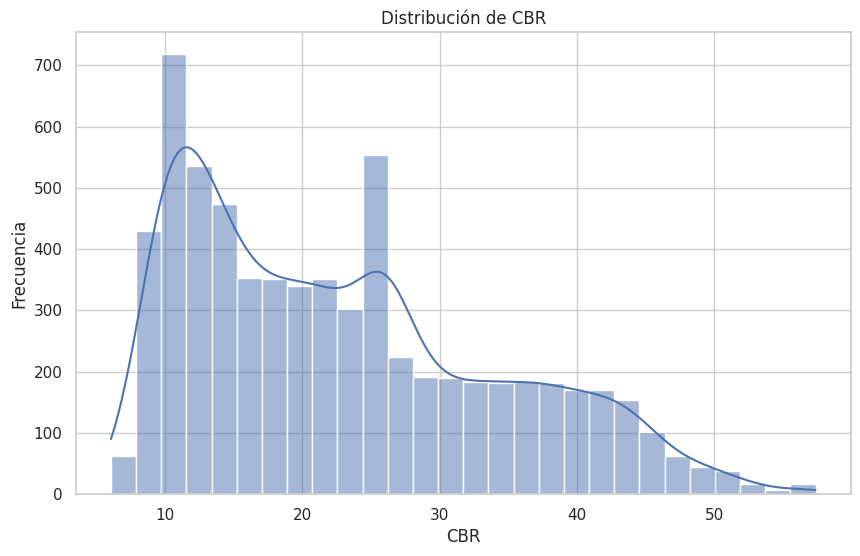

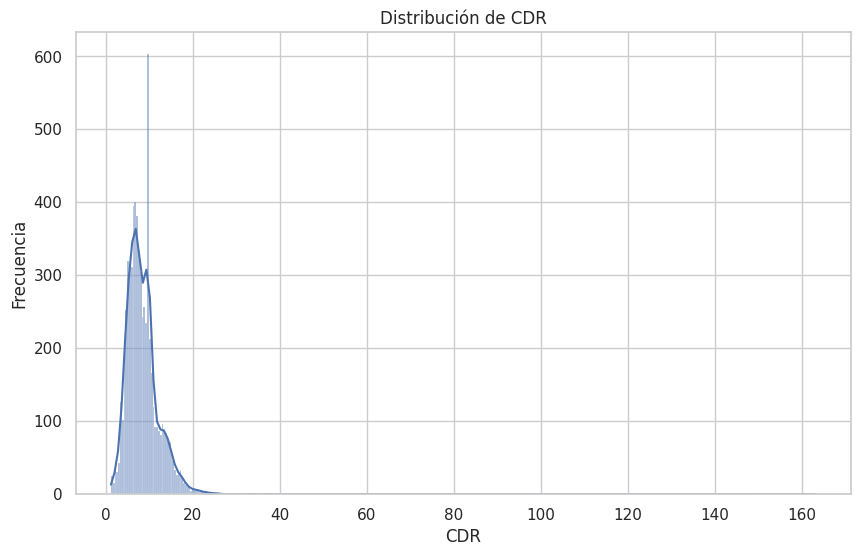

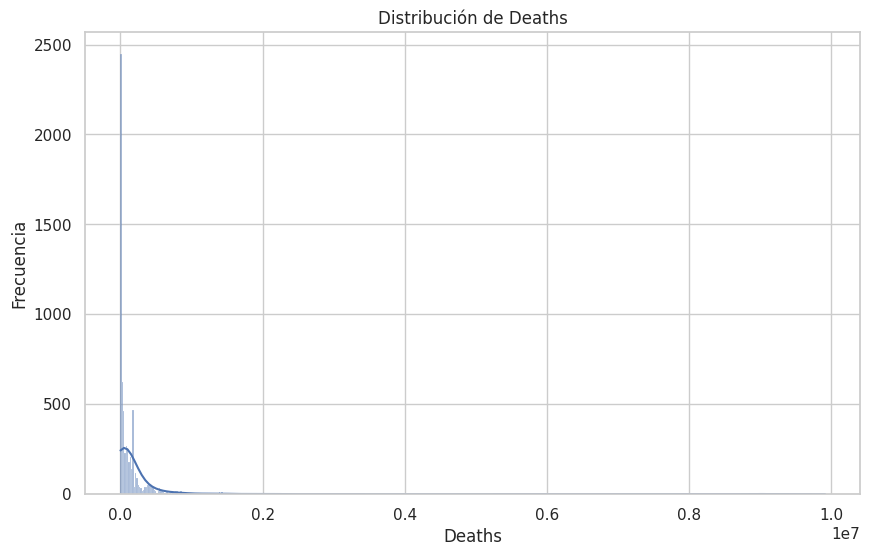

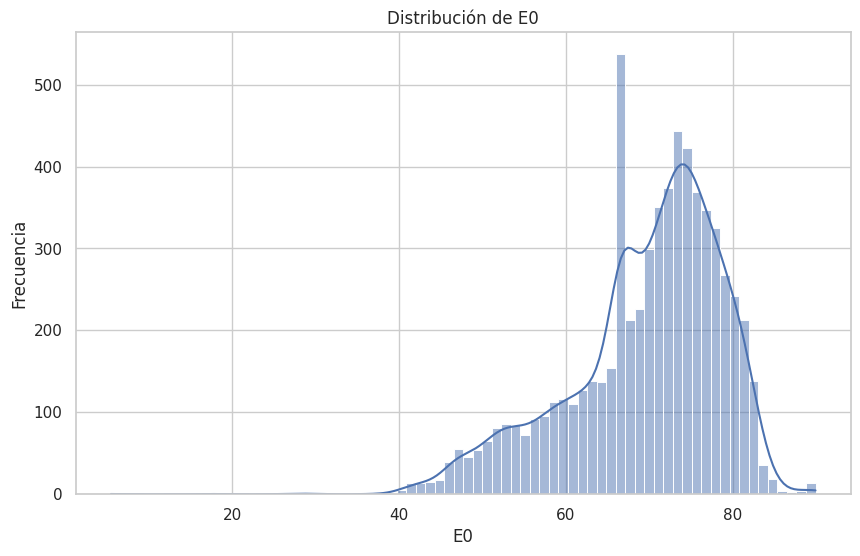

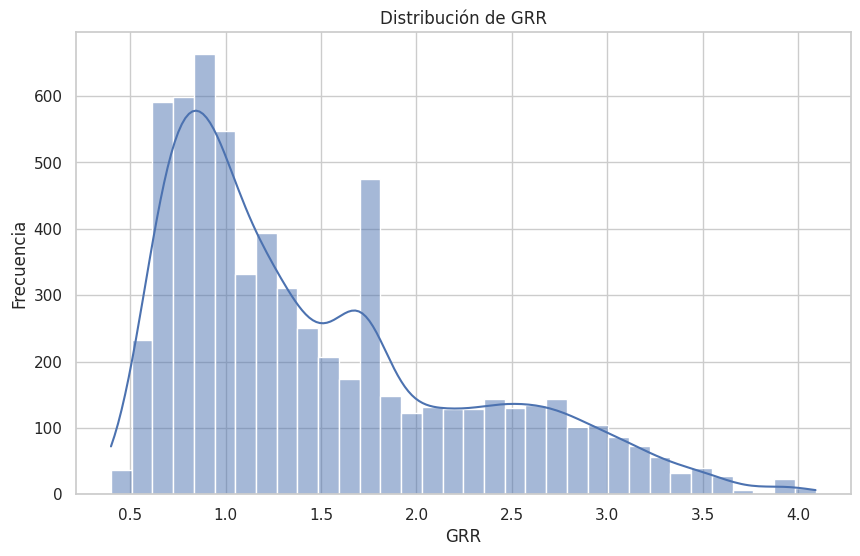

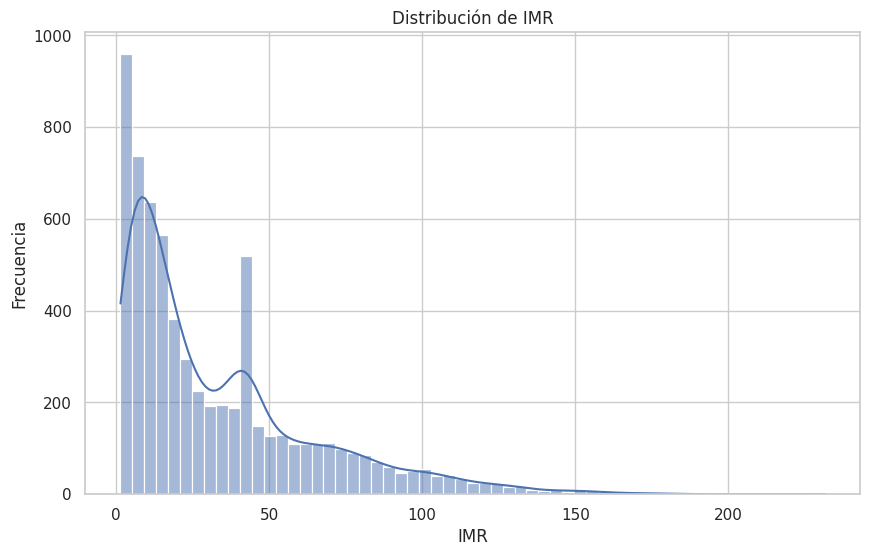

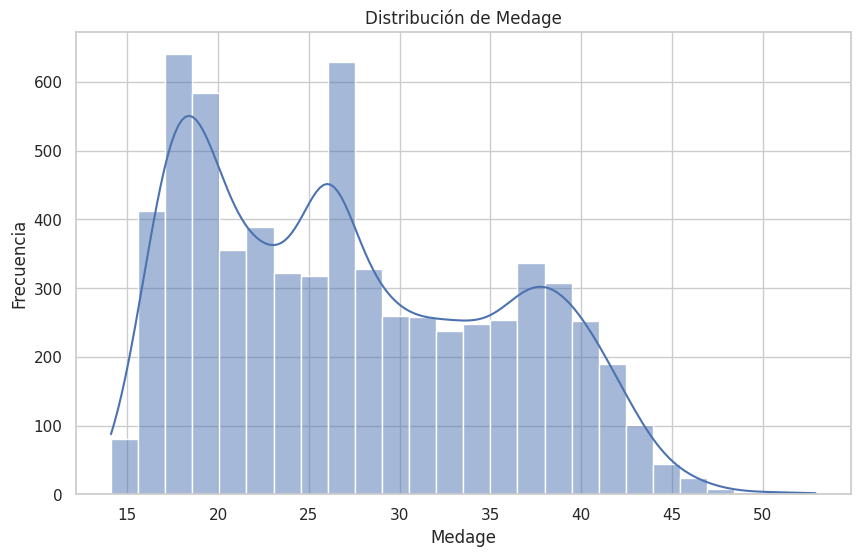

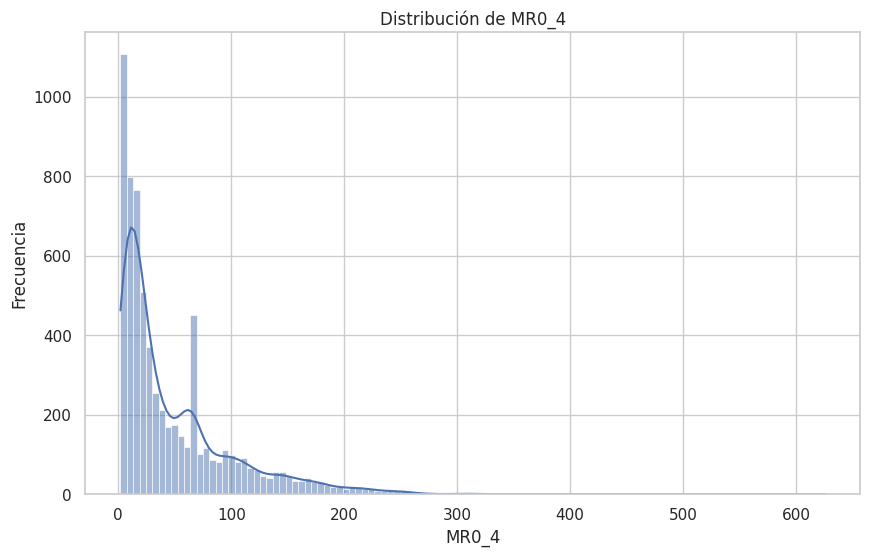

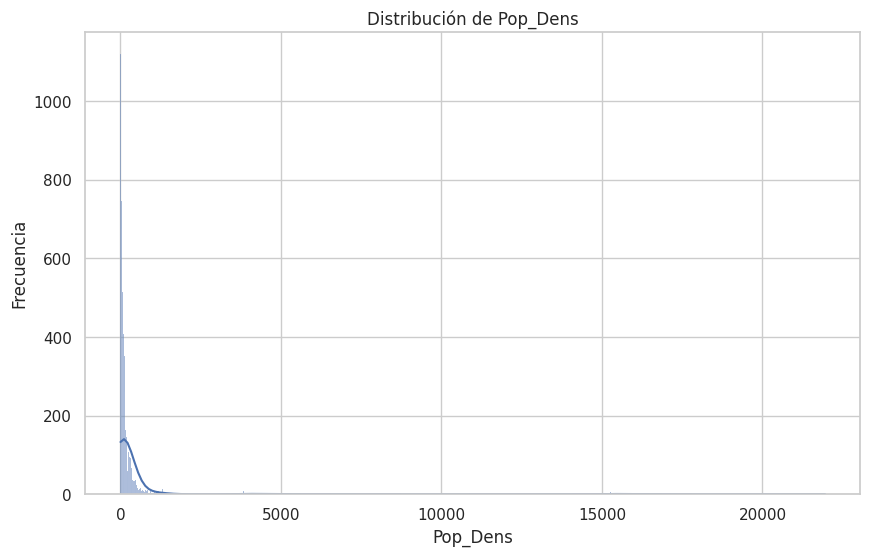

In [89]:
# Convertir Spark DataFrame a Pandas DataFrame
dem_pd = dem_imputed.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

# Configurar el estilo visual de los gráficos de Seaborn
sns.set(style="whitegrid")
columns = ['CBR', 'CDR', 'Deaths', 'E0', 'GRR', 'IMR', 'Medage', 'MR0_4','Pop_Dens']
# Iterar a través de cada columna en el DataFrame
for column in columns:
    # Determinar si la variable es numérica o categórica
    if dem_pd[column].dtype in ['int64', 'float64']:  # Si la variable es numérica
        plt.figure(figsize=(10, 6))
        sns.histplot(dem_pd[column], kde=True)  # Histograma con estimación de densidad
        plt.title(f'Distribución de {column}')
        plt.xlabel(column)
        plt.ylabel('Frecuencia')
    else:  # Si la variable es categórica
        plt.figure(figsize=(10, 6))
        sns.countplot(y=column, data=dem_pd)  # Gráfico de conteo para variables categóricas
        plt.title(f'Distribución de {column}')
        plt.xlabel('Conteo')
        plt.ylabel(column)
    plt.show()


### *Guardem les bases de dades filtrades*

In [ ]:
dem_mod.write \
    .format("jdbc") \
    .option("url", "jdbc:duckdb:demography_1.db") \
    .option("dbtable", "dem") \
    .option("driver", "org.duckdb.DuckDBDriver") \
    .save()

soc_mod.write \
    .format("jdbc") \
    .option("url", "jdbc:duckdb:soc_1.db") \
    .option("dbtable", "soc") \
    .option("driver", "org.duckdb.DuckDBDriver") \
    .save()

mh.write \
    .format("jdbc") \
    .option("url", "jdbc:duckdb:mh_1.db") \
    .option("dbtable", "mh") \
    .option("driver", "org.duckdb.DuckDBDriver") \
    .save()


### **Estudi de les bases de dades**

    Aquesta secció té com a objectiu estudiar les bases de dades, juntament amb les seves corresponents correlacions i covariançes. L'objectiu d'aquesta anàlisi és determinar si hi ha alguna columna redundant, explorar la possibilitat de combinar columnes o eliminar-ne alguna que no sigui rellevant per als nostres objectius

In [ ]:
import pandas as pd
from pyspark.sql.functions import col
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df_soc = pd.read_csv("/content/betterlifebetterhealth/data/society.csv")
df_mh = pd.read_csv("/content/betterlifebetterhealth/data/mental_health.csv")
df_dem = pd.read_csv("/content/betterlifebetterhealth/data/demography.csv")

/tmp/ipykernel_31827/886766473.py:2: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mh = pd.read_csv("/content/betterlifebetterhealth/data/mental_health.csv")


#### **Estudi de la base de dades relativa a la societat**

In [ ]:
df_soc.describe()
df_soc.describe().to_csv('descripció_soc.csv', index=True)

Les tasques a fer en aquesta secció són les següents:

*   Unir les columnes referents a la població separades per gènere.
*   Fer la mitjana per l'esperança de vida d'homes i dones, general i en nèixer
* Eliminar les columnes:
  *   Total fertility rate
  *   Adolescent fertility rate
  * Female part-time employment, percent of both sexes
  * Gender pay gap in hourly earning wage rate
  * GDP at current prices, millions of NCUs
  * GDP per capita at current prices and PPPs, US
  * GDP per capita at current prices, NCUs
  * Persons injured in road accidents
  * Persons killed in road accidents
  * Exchange rate (XR), NCU per US$


* Unir les columnes referents a l'ús de l'ordinador per edats separades per gènere (o eliminar, hi ha molt NULL, a veure què ha fet el Joan)

* Columnes que unirem segons un índex de avenç segons el gènere:
  * Women Researchers, Percent of corresponding total for both sexes
  * Female legislators, senior officials and managers, percent of total
  * Female professionals, percent of total for both sexes
  * Female clerks, percent of total for both sexes
  * Female craft and related workers, percent of total for both sexes
  * Female plant and machine operators and assemblers, percent of total for both sexes
  * Female government ministers, percent of total
  * Female members of parliament, percent of total
  * Female ambassadors, percent of total
  * Female judges, percent of total

* Unir les columnes relatives a l'activitat econòmica entre els 15 i els 64 anys separades per gènere (molts NULL també, esperar al Joan)










In [ ]:
soc = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:duckdb:/content/soc_1.db") \
    .option("driver", "org.duckdb.DuckDBDriver") \
    .option("dbtable", "soc") \
    .load()

In [ ]:
columnes_a_eliminar = [
    'Total fertility rate',
    'Adolescent fertility rate',
    'Female part-time employment, percent of both sexes',
    'Gender pay gap in hourly earning wage rate',
    'GDP at current prices, millions of NCUs',
    'GDP per capita at current prices and PPPs, US',
    'GDP per capita at current prices, NCUs',
    'Persons injured in road accidents',
    'Persons killed in road accidents',
    'Exchange rate (XR), NCU per US$'
]

# Eliminar les columnes
soc = soc.drop(*columnes_a_eliminar)

In [ ]:
# Unir les columnes referents a la població separades per gènere.
columnes_a_unir = [
    ('Population aged 0-14, male','Population aged 0-14, female'),
    ('Population aged 15-64, male','Population aged 15-64, female'),
    ('Population aged 64+, male','Population aged 64+, female')
]

for i,j in columnes_a_unir:
  # Definir el nou nom de la columna resultant
  nou_nom_columna = i.split(",")[0]
  # Crear la nova columna amb la suma de les dues columnes
  soc = soc.withColumn(nou_nom_columna, col(i) + col(j))

  # Eliminar les columnes originals
  soc= soc.drop(i, j)

In [ ]:
# Fer la mitjana per l'esperança de vida d'homes i dones, general i en nèixer
columnes_a_unir = [
    ('Life expectancy at birth, women','Life expectancy at birth, men'),
    ('Life expectancy at age 65, women','Life expectancy at age 65, men'),
]

for i,j in columnes_a_unir:
  # Definir el nou nom de la columna resultant
  nou_nom_columna = i.split(",")[0]
  # Crear la nova columna amb la mitjana de les dues columnes
  soc = soc.withColumn(nou_nom_columna, (col(i) + col(j)) / 2)

  # Eliminar les columnes originals
  soc= soc.drop(i, j)

In [ ]:
# Fer la mitjana per l'esperança de vida d'homes i dones, general i en nèixer
columnes_a_unir = [
    ('Economic activity rate, women 15-64','Economic activity rate, men 15-64'),
]

for i,j in columnes_a_unir:
  # Definir el nou nom de la columna resultant
  nou_nom_columna = i.split(",")[0] + 'rate'
  # Crear la nova columna amb la mitjana de les dues columnes
  soc = soc.withColumn(nou_nom_columna, (col(i) + col(j)) / 2)

  # Eliminar les columnes originals
  soc= soc.drop(i, j)


In [ ]:
soc.show()

+-------+----+------------------------+----------------+------------------------------------+--------------------------+----------------------------+-----------------------------------------+-------------------------+---------------------------+-------------------------+---------------------------+-------------------------+---------------------------+------------------------------------------------------------------------+----------------------------------+------------------------------------------+----------------------------------------------------------------+-------------------------------------------------------------------+-----------------------------------------------------+----------------------------------------------+-----------------------------------------------------------------+----------------------------------------------------------------------------------+---------------------------------------------+----------------------------------------------+--------------------

    Observem les correlacions amb l'objectiu de saber si hi ha alguna variable més que puguem eliminar

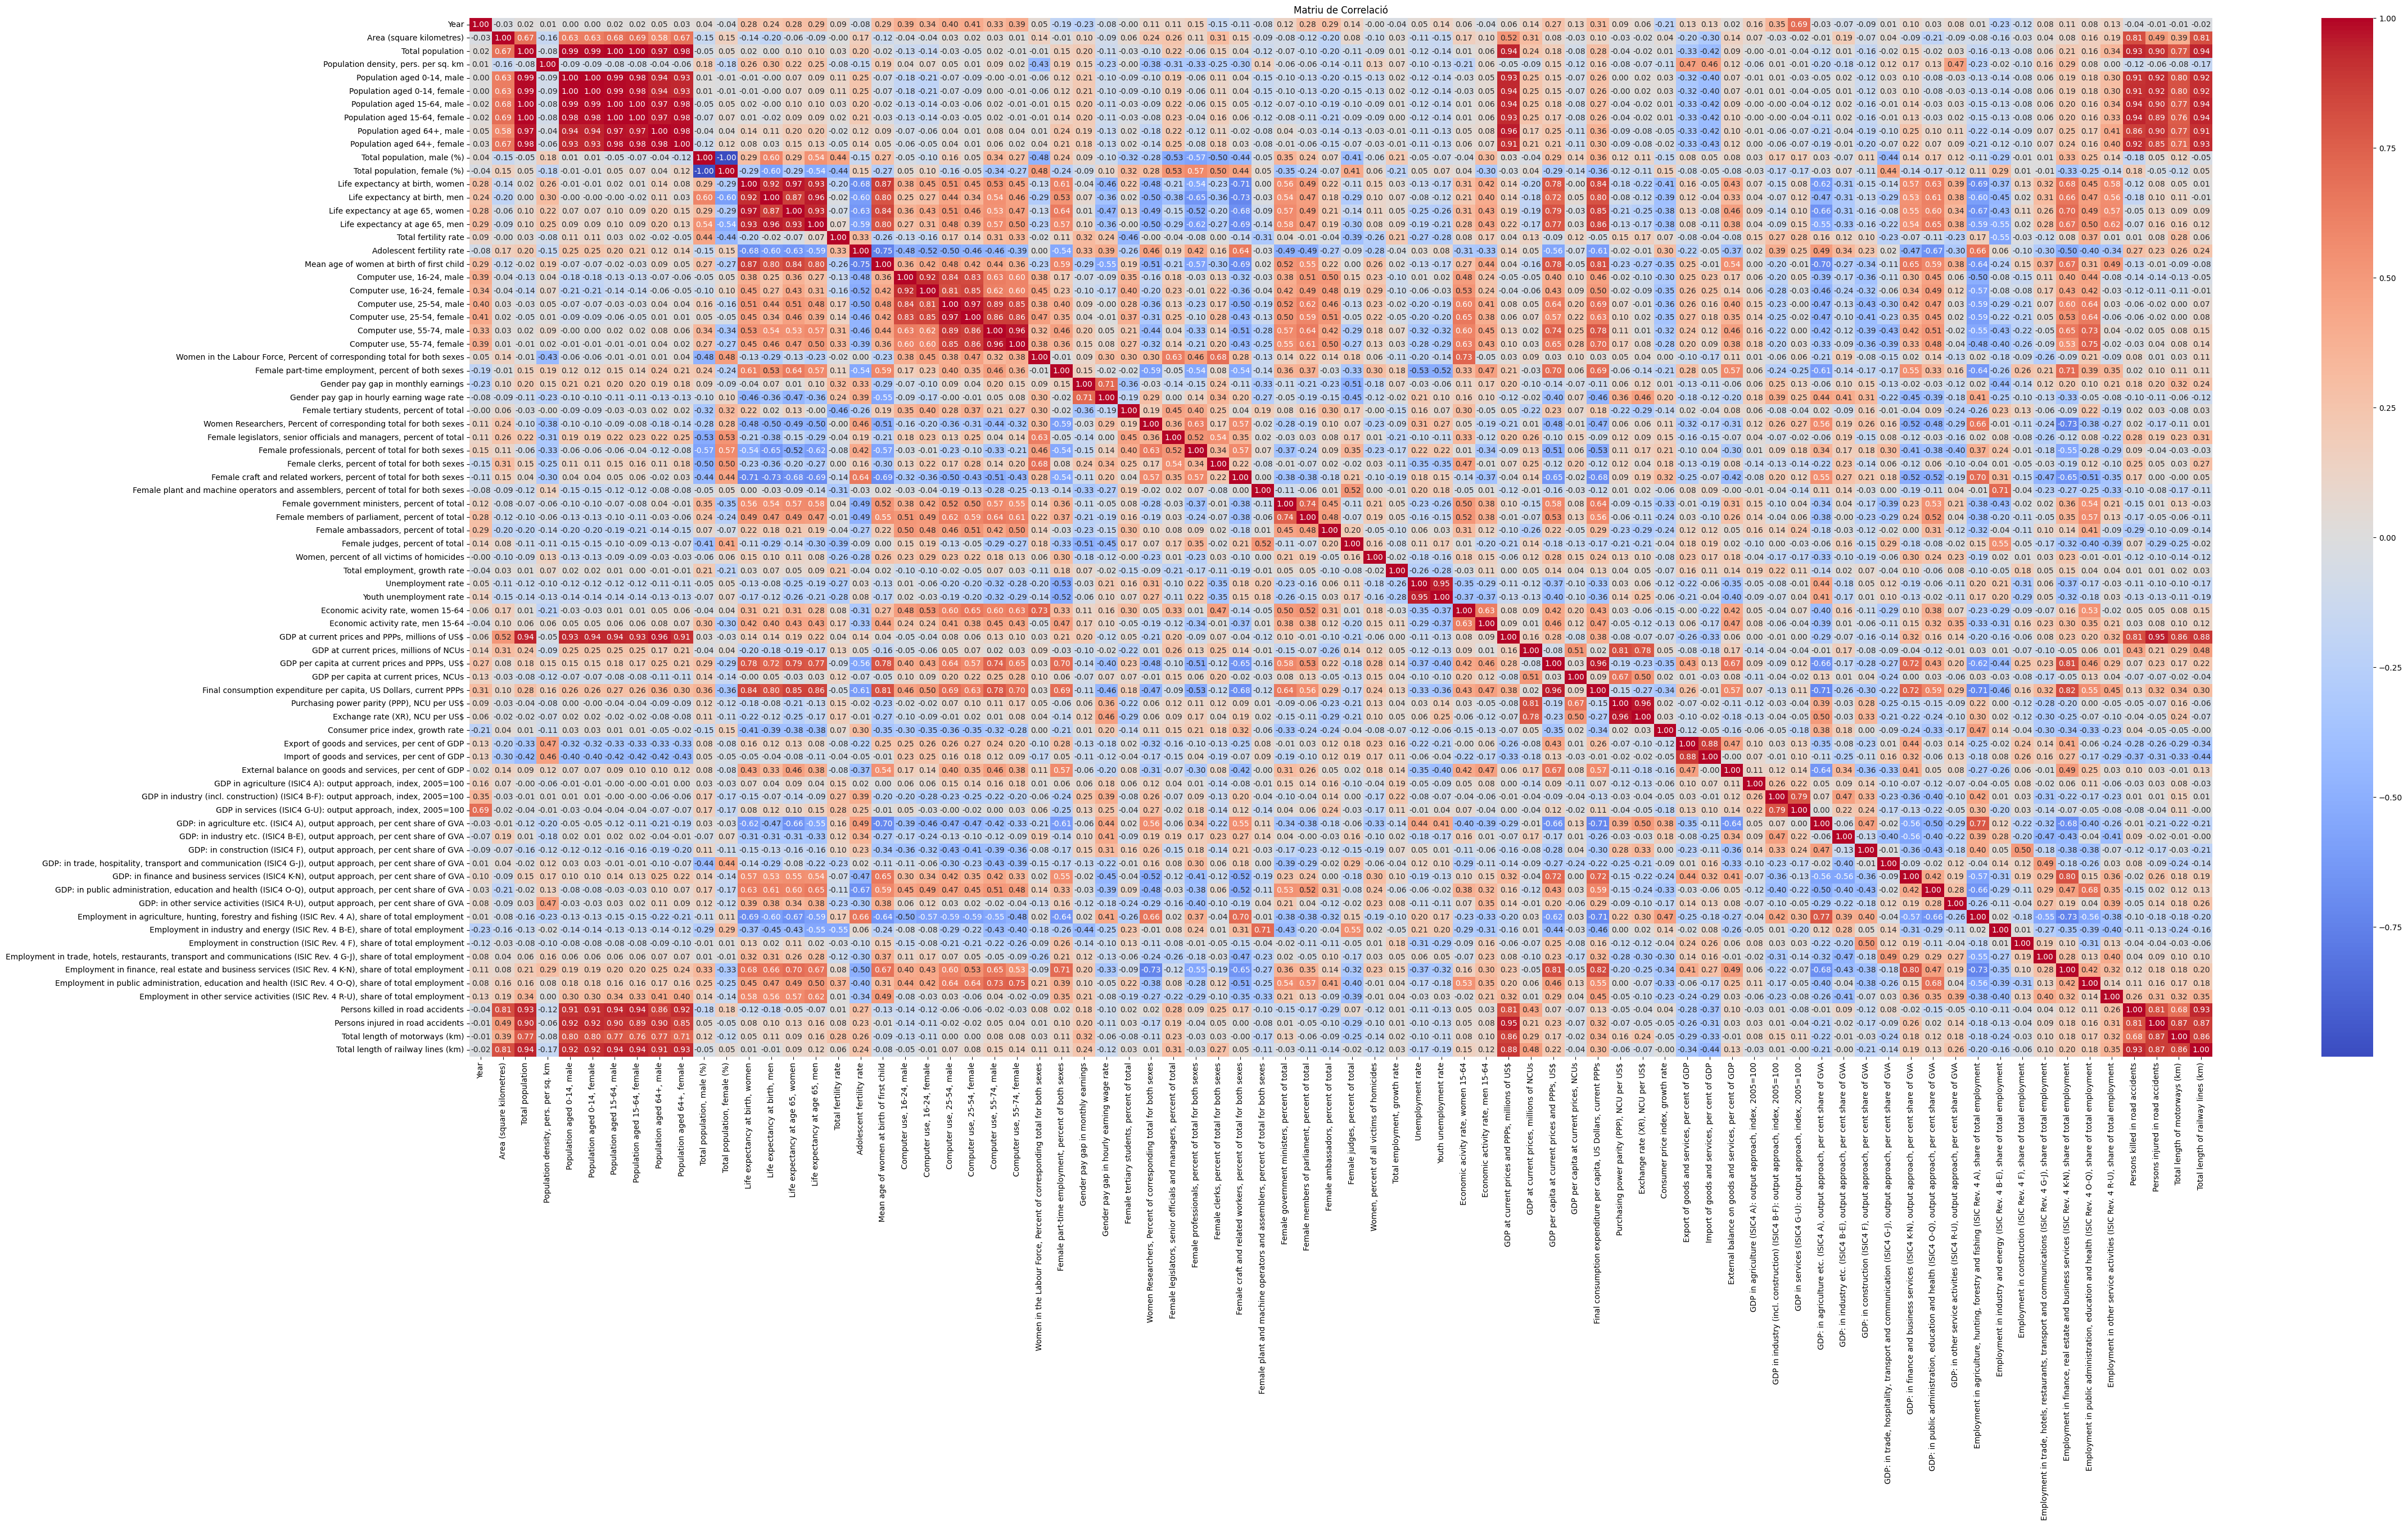

In [ ]:
df_num = df_soc.select_dtypes(include=['float64', 'int64'])
matr_corr = df_num.corr()
plt.figure(figsize=(50, 24))
sns.heatmap(matr_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriu de Correlació')
plt.show()